In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
   # for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

![alt](http://docs.fast.ai/imgs/u-net-architecture.png)

#### We will be using the DynamicUnet architecture for the following from fastai.vision 
#### This U-Net will sit on top of an encoder (that can be a pretrained model) and with a final output of n_classes. During the initialization, it uses Hooks to determine the intermediate features sizes by passing a dummy input through the model and create the upward path automatically.

#### Importing the required packages from fastai

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
# get the Path of the mask for a given image
path_mask = lambda x: x.parents[0] / (x.stem + '_mask' + x.suffix)

data_path = Path('/kaggle/input/lgg-mri-segmentation/kaggle_3m/')

#### Lets Visualise an image from the given dataset along with its mask

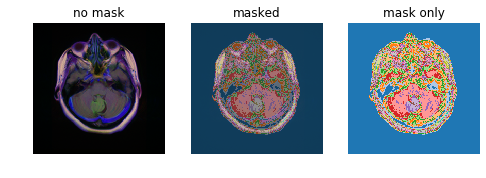

In [4]:
img = open_image('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif')
mask = open_mask('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif')
_,axs = plt.subplots(1,3, figsize=(8,4))
img.show(ax=axs[0], title='no mask')
img.show(ax=axs[1], y=mask, title='masked')
mask.show(ax=axs[2], title='mask only', alpha=1.)

#### Lets predefine the set of validation images

In [5]:
validation_folders = [
        'TCGA_HT_7694_19950404', 'TCGA_DU_5874_19950510', 'TCGA_DU_7013_19860523',
        'TCGA_HT_8113_19930809', 'TCGA_DU_6399_19830416', 'TCGA_HT_7684_19950816',
        'TCGA_CS_5395_19981004', 'TCGA_FG_6688_20020215', 'TCGA_DU_8165_19970205',
        'TCGA_DU_7019_19940908', 'TCGA_HT_7855_19951020', 'TCGA_DU_A5TT_19980318',
        'TCGA_DU_7300_19910814', 'TCGA_DU_5871_19941206', 'TCGA_DU_5855_19951217']

In [6]:
# thanks to https://www.kaggle.com/tanlikesmath/ultrasound-nerve-segmentation-with-fastai/data for showing how this can be done
class SegmentationLabelListWithDiv(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
class SegmentationItemListWithDiv(SegmentationItemList):
    _label_cls = SegmentationLabelListWithDiv

In [7]:
codes=['n','y']

src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([256, 256]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [8]:
src = (SegmentationItemListWithDiv.from_folder(data_path, recurse=True)
       .filter_by_func(lambda x: not x.name.endswith('_mask.tif'))
       .split_by_valid_func(lambda x: x.parts[-2] in validation_folders)
       .label_from_func(path_mask, classes=codes))

In [9]:
data = (src.transform(get_transforms(), size=src_size, tfm_y=True)
        .databunch(bs=32)
        .normalize(imagenet_stats))

### Method to save the model in the directory and to display the predicted images vs the ground truth

In [10]:
def save_and_show(name):
    saved_to = learn.save(name, return_path=True)
    print('Saved to', saved_to, 'Note: this will be lost unless we commit the kernel')
    learn.load(name) # free memory etc
    learn.show_results(rows=8, figsize=(32, 32))

### Calling the unet_learner and using pretrained resnet34 architecture as its initial backbone structure,metrics used is dice and for weight_decay(wd) we are using 1e-1 

In [11]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=1e-1, path='/kaggle/working')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


#### finding the optimum learning rate for our comparison by doing an LR range test.**

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


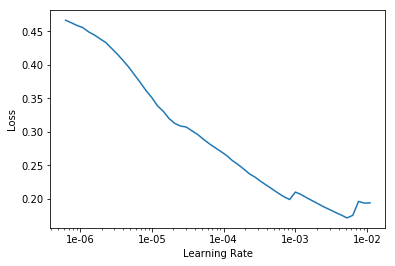

In [12]:
learn.lr_find()
learn.recorder.plot()

#### running one fit_cycle with lr=5e-3

epoch,train_loss,valid_loss,dice,time
0,0.034192,0.014077,0.811850,01:25
1,27.560614,0.154048,0.667969,01:24
2,3.382089,0.019330,0.778279,01:24
3,0.413626,0.015250,0.804395,01:24
4,0.062086,0.014391,0.804336,01:24


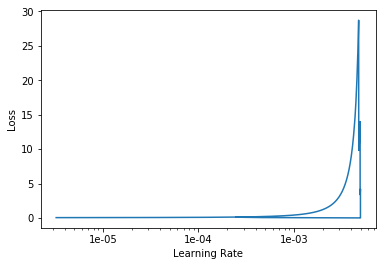

In [13]:
#lr_find(learn)
learn.fit_one_cycle(5, 5e-3)
learn.recorder.plot()

In [14]:
!pip install neptune-contrib
!pip install neptune-contrib[monitoring]

     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 2.1 MB 45.1 MB/s 
     |████████████████████████████████| 61 kB 5.2 MB/s 
     |████████████████████████████████| 138 kB 53.5 MB/s 
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for neptune-contrib: filename=neptune_contrib-0.16.2-py3-none-any.whl size=48304 sha256=5339ad70e4c7229283cfd7f0fc126a818ed394fc58fb9d468a773d5820ac7233
  Stored in directory: /root/.cache/pip/wheels/83/e3/12/4080efa812c137db0d38405be139b7c3130cbcaaa571781f22
  Created wheel for neptune-client: filename=neptune_client-0.4.107-py2.py3-none-any.whl size=145063 sha256=465674684b859d0d871951ee1d2420846abd4d785ef77a33bd139013f04decdf
  Stored in directory: /root/.cache/pip/wheels/89/aa/52/3a41cf275c67b40e4021b07bbcba07c07bd40863078d239d5e
  Created wheel for msgpack-python: filename=msgpack_python-0.5.6-cp36-cp36m-linux_x86_64.whl size=293793 sha256=64779aa4002a7ea5184d11e7186e120ea8994bc54bae1ae

In [15]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("api_token_neptune")

In [16]:
import neptune
from neptunecontrib.monitoring.fastai import NeptuneMonitor

neptune.init('aninda/sandbox',
             api_token=secret_value_0)

with neptune.create_experiment(name='FastAI_MRI_segmentation',params={'lr': 1e-2}):
    neptune.append_tag('First_logger')
    learn.callbacks.append(NeptuneMonitor())
    learn.fit_one_cycle(20, slice(2e-3))

https://ui.neptune.ai/aninda/sandbox/e/SAN-8


epoch,train_loss,valid_loss,dice,time
0,0.014865,0.014461,0.809767,01:25
1,0.014257,0.013821,0.817971,01:24
2,0.014293,0.014227,0.789697,01:24
3,0.013141,0.013363,0.829576,01:24
4,0.012416,0.011016,0.827546,01:25
5,0.013136,0.011458,0.819747,01:24
6,0.010764,0.010722,0.843986,01:24
7,0.010057,0.012030,0.855749,01:24
8,0.009034,0.010592,0.856369,01:24
9,0.008669,0.009566,0.868681,01:25


Saved to /kaggle/working/models/stage-1.pth Note: this will be lost unless we commit the kernel


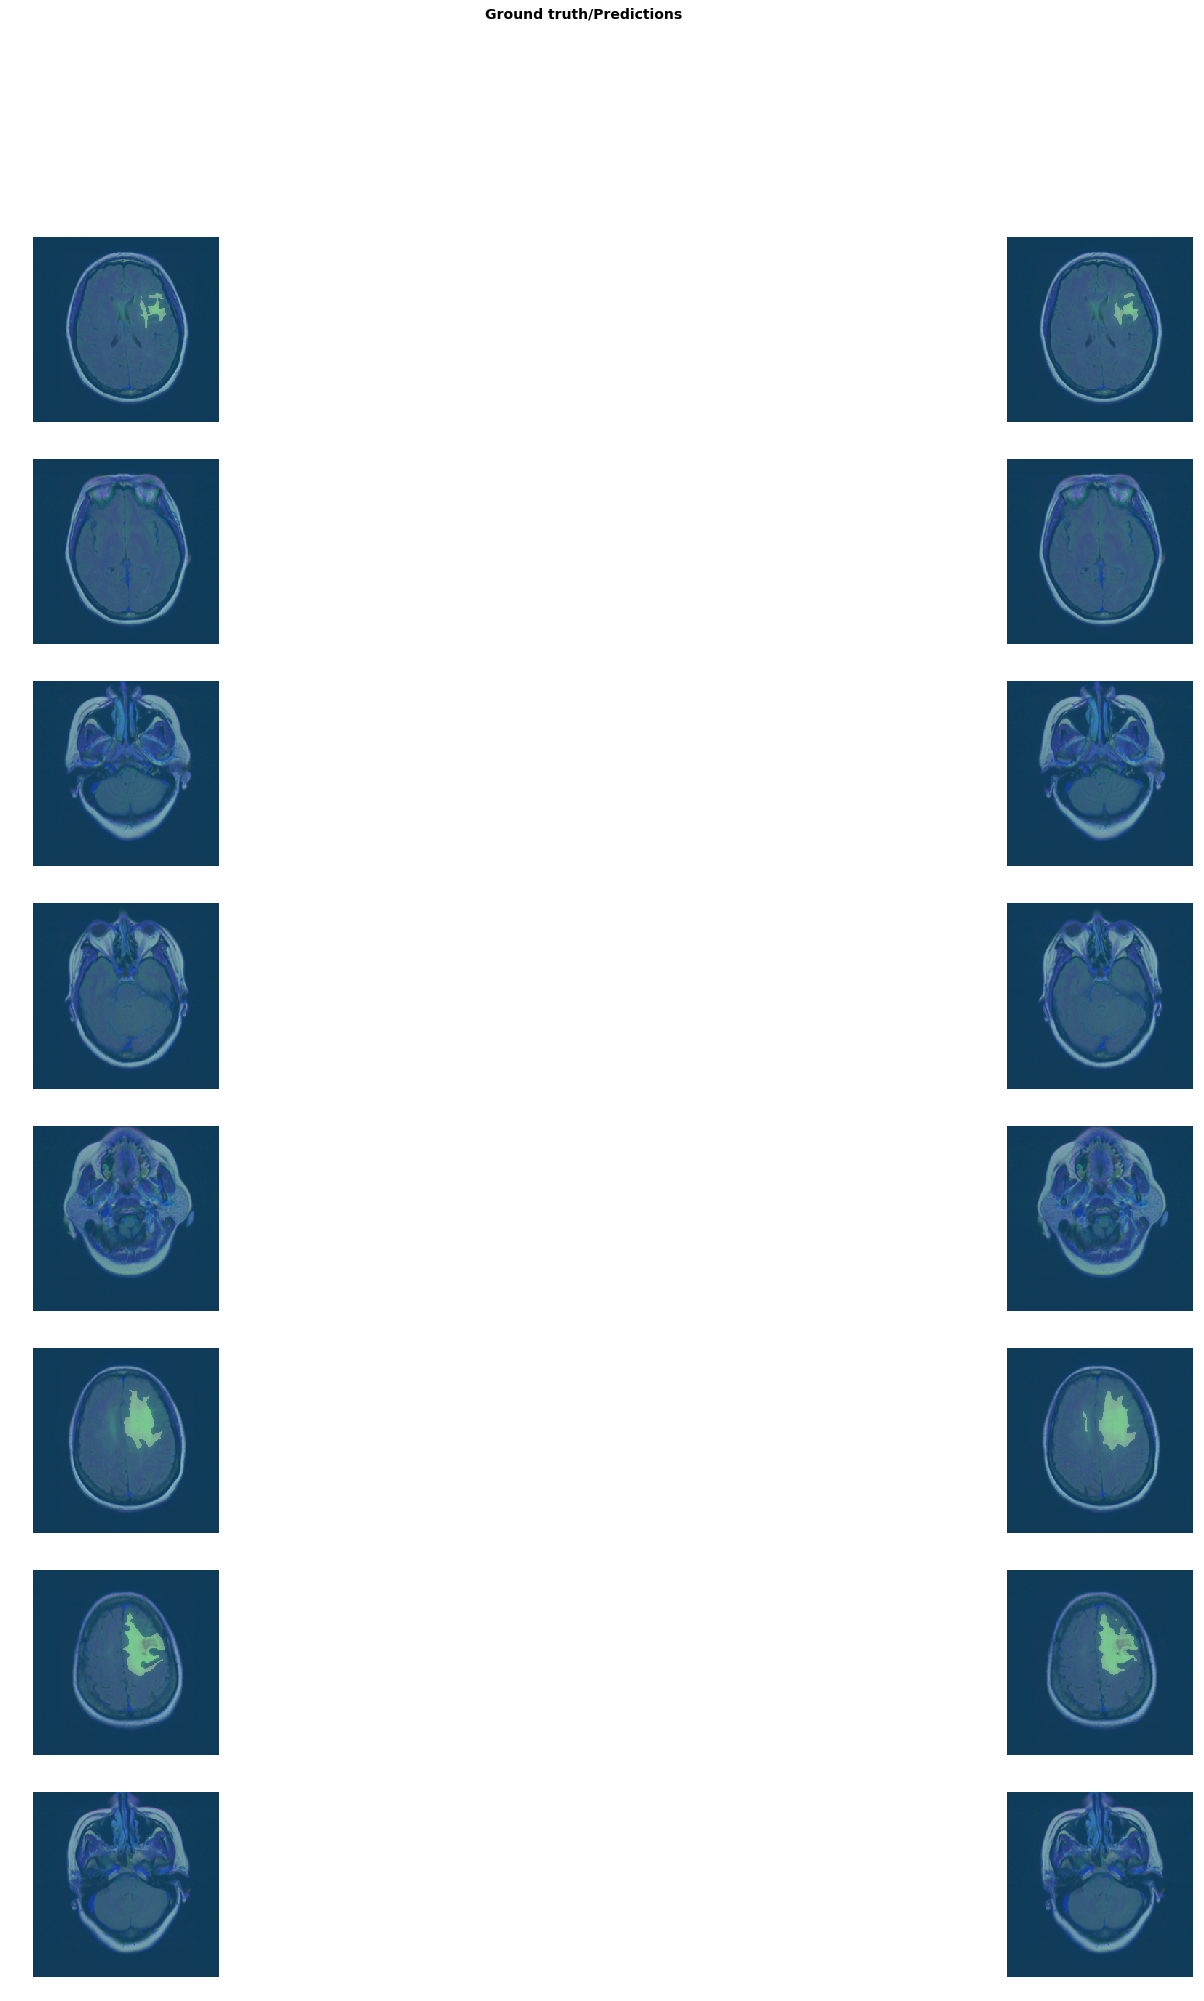

In [17]:
save_and_show('stage-1')

Saved to /kaggle/working/models/stage-2.pth Note: this will be lost unless we commit the kernel


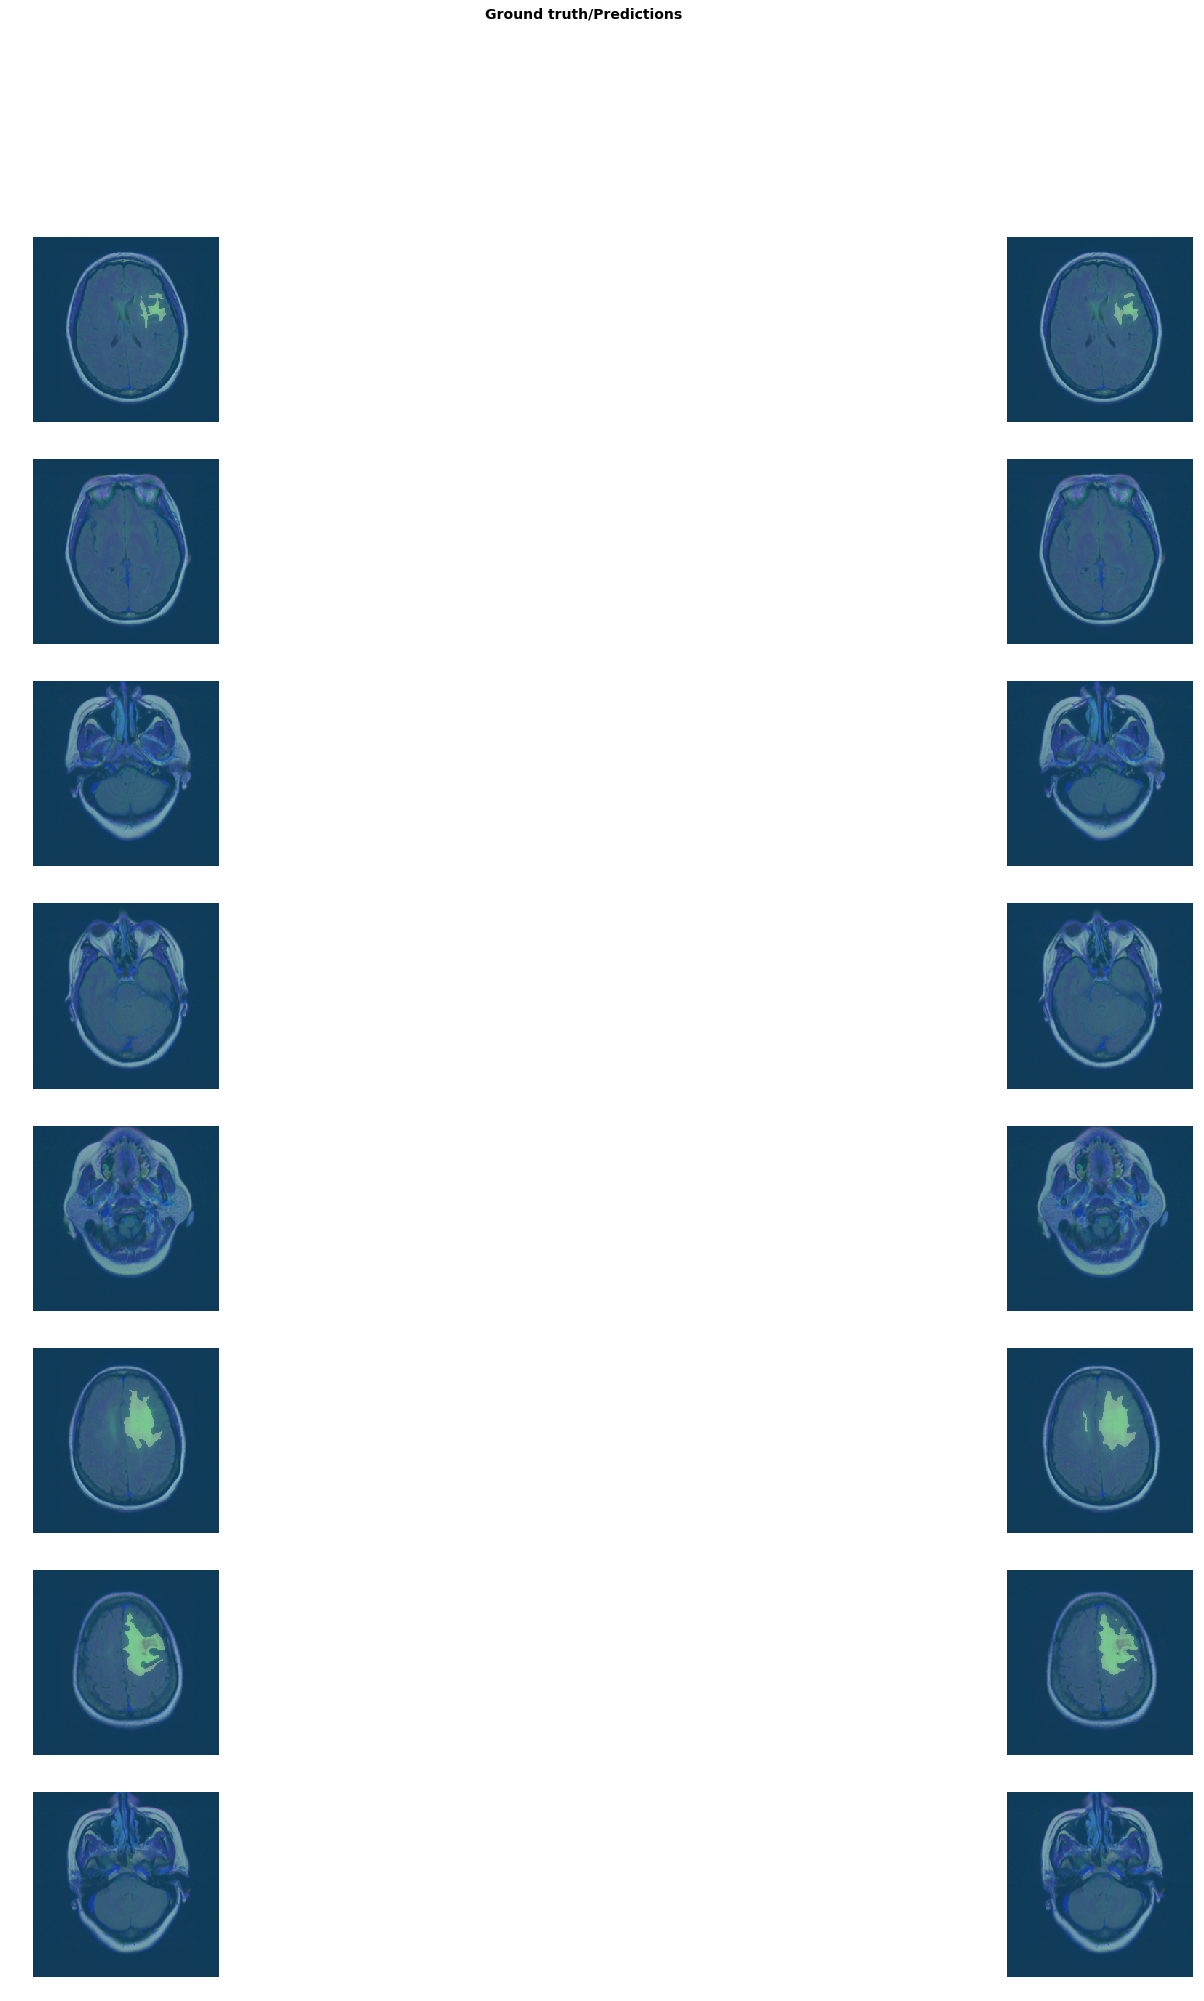

In [18]:
save_and_show('stage-2')